In [14]:
from numpy import *
import qiskit.quantum_info as qi
from qiskit import *

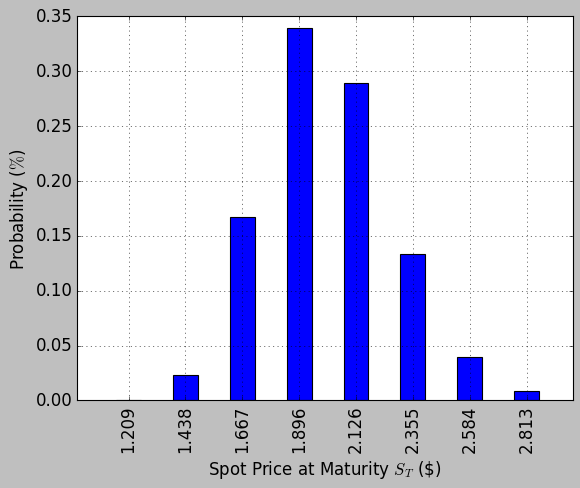

[1.20860724 1.43785917 1.66711109 1.89636302 2.12561495 2.35486687
 2.5841188  2.81337073]
1.0


In [15]:
import matplotlib.pyplot as plt
from qiskit_finance.circuit.library import LogNormalDistribution

#parametri finanziari
S0 = 2  
sigma = 0.4
r = 0.05
T = 40/365
K=1.896


#parametri della distribuzione
mu = (r - 0.5 * sigma**2) * T + log(S0)
sigmad = sigma * sqrt(T)
mean = exp(mu + sigmad**2 / 2)
variance = (exp(sigmad**2) - 1) * exp(2 * mu + sigmad**2)
stddev = sqrt(variance)
n=3 #log 2 del numero di qubit

low = maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

#generazione della distribuzione
Distr = LogNormalDistribution(
    n, mu=mu, sigma=sigmad**2, bounds=(low, high)
)

x = Distr.values
y = Distr.probabilities
plt.style.use('classic')
plt.bar(x, y, width=0.1)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()
print(Distr.values)
print(sum(Distr.probabilities))


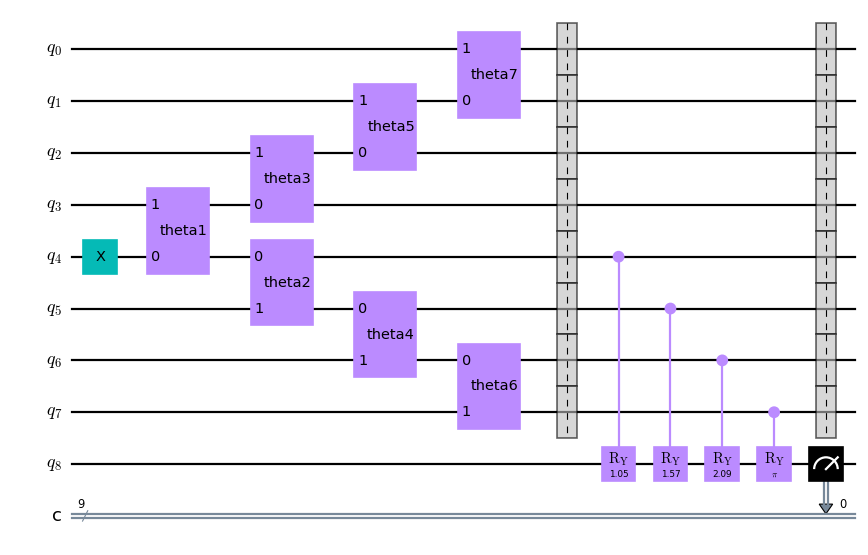

In [16]:
a=zeros(2**n)
thetas = zeros(2**n-1)
#Definiizone delle ampiezze sulla base della distribuzione cercata
for i in range(len(a)):
    a[i]=sqrt(Distr.probabilities[i])

#Definizione degli angoli agli estremi
thetas[-1]=arctan(a[0]/a[1])
thetas[-2]=arctan(a[-1]/a[-2])

#Definizione degli angoli intermedi
for i in range(int(len(a)/2)-2):
    thetas[-3-i*2]=arctan(a[i+1]/(a[i+2]*cos(thetas[2**n-2*(i+1)])))
    thetas[-4-i*2]=arctan(a[-i-2]/(a[-i-3]*cos(thetas[2**n-1-2*(i+1)])))
    
#definizione dell'angolo centrale (theta1)
thetas[0]=arctan((a[2**(n-1)-1]*cos(thetas[1]))/(a[2**(n-1)]*cos(thetas[2])))

#Definizione dei gates p-swap
for i in range(len(a)-1):
    string = "p_swap"+str(i+1)+"=qi.Operator([[1, 0, 0, 0],[0, cos(thetas["+str(i)+"]), \
    sin(thetas["+str(i)+"]), 0],[0, -sin(thetas["+str(i)+"]), cos(thetas["+str(i)+"]), 0],[0, 0, 0, 1]])"
    exec(string)
    

    
circ = QuantumCircuit(2**n+1)
meas = QuantumCircuit(2**n+1,2**n+1)
meas.x(2**(n-1))

#Applicazione dei gates p-swap al circuito
string = "meas.unitary(p_swap1, [2**(n-1),2**(n-1)-1],label='theta1')"
exec(string)
for i in range(2**(n-1)-1):
    string1 = "meas.unitary(p_swap"+str(3+2*i)+", ["+str(2**(n-1)-1-i)+","+str(2**(n-1)-2-i)+"]\
    ,label='theta"+str(3+2*i)+"')"
    string2 = "meas.unitary(p_swap"+str(2+2*i)+", ["+str(2**(n-1)+i)+","+str(2**(n-1)+i+1)+"],\
    label='theta"+str(2+2*i)+"')"
    exec(string1)
    exec(string2)

meas.barrier(range(2**n))
#Ricerca del qubit che codifica il primo prezzo maggiore dello strike price
ik=0;
for i in range(len(a)):
    if Distr.values[i]>K:
        ik=i+1
        break
#Applicazione delle rotazioni controllate (CRY)
for i in range(ik,len(a)):
    string = "meas.cry(2*arcsin(sqrt((Distr.values["+str(i)+"]-K)/(high-K))),"+str(i)+","+str(2**n)+")"
    exec(string)

meas.barrier(range(2**n))
circ.add_register(meas.cregs[0])
#misura del qubit di appoggio
meas.measure(2**n,0)


qc = circ.compose(meas)



meas.draw()
    


{1: 1782, 0: 8218}
[   4.53737474  229.31230058 1668.17633387 3397.75309649 2893.65313641
 1331.00211697  392.23795624   83.3276847 ]


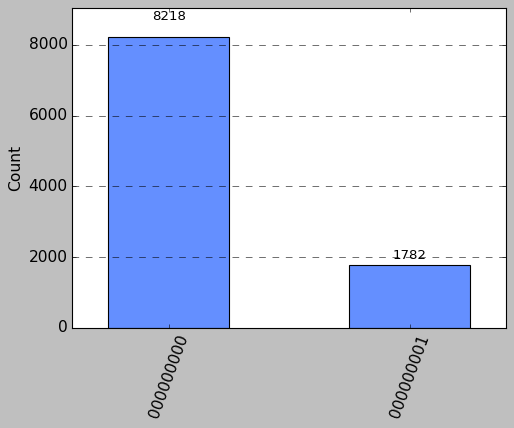

In [17]:

backend_sim = Aer.get_backend('qasm_simulator')

nshots=10**4
job_sim = backend_sim.run(transpile(qc, backend_sim), shots=nshots)


result_sim = job_sim.result()
counts = result_sim.get_counts(qc)


from qiskit.visualization import plot_histogram
print(counts.int_raw)
print(y*nshots)
plot_histogram(counts)




In [18]:
print(counts.int_raw)

{1: 1782, 0: 8218}


In [19]:
#val=[0,(counts.int_raw[2]/nshots),
#(counts.int_raw[4]/nshots),
#(counts.int_raw[8]/nshots),
#(counts.int_raw[16]/nshots),
#(counts.int_raw[32]/nshots),
#(counts.int_raw[64]/nshots),
#(counts.int_raw[128]/nshots)]


payoff = maximum(0, Distr.values - K)
#V=dot(Distr.values[3:7]-K,val[3:7])
ex=dot(payoff,Distr.probabilities)
#print(Distr.values[3:7])
#print(Distr.probabilities[3:7])
#print(V)
#print(ex)


In [20]:
payoff = maximum(0, Distr.values - K)
ex=dot(payoff,Distr.probabilities)
print("best=",ex)
print("ris =",counts.int_raw[1]*(high-K)/nshots)

best= 0.16227609350087316
ris = 0.16347546374669975


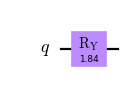

In [23]:
#SOLO PER 8 QUBIT !!!!
import numpy as np
from qiskit.circuit import QuantumCircuit


class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self):
        super().__init__(1)  # circuit on 1 qubit
        #theta_p = 2 * np.arcsin(np.sqrt(0.7))
        theta_p = 2*a[4]*arcsin(sqrt((Distr.values[4]-K)/(high-K)))+2*a[5]*arcsin(sqrt((Distr.values[5]-K)/(high-K)))+2*a[6]*arcsin(sqrt((Distr.values[6]-K)/(high-K)))+2*a[7]*arcsin(sqrt((Distr.values[7]-K)/(high-K)))
        self.ry(theta_p, 0)


class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self):
        super().__init__(1)  # circuit on 1 qubit
        #self._theta_p = 2 * np.arcsin(np.sqrt(0.7))
        self._theta_p = 2*a[4]*arcsin(sqrt((Distr.values[4]-K)/(high-K)))+2*a[5]*arcsin(sqrt((Distr.values[5]-K)/(high-K)))+2*a[6]*arcsin(sqrt((Distr.values[6]-K)/(high-K)))+2*a[7]*arcsin(sqrt((Distr.values[7]-K)/(high-K)))

        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k
    
    
A = BernoulliA()

Q = BernoulliQ()    
    
from qiskit.algorithms import EstimationProblem

problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)
A.draw()

In [24]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance

backend = BasicAer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend)



/tmp/ipykernel_190/719769340.py:5: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend)


In [25]:
from qiskit.algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    quantum_instance=quantum_instance,
)
iae_result = iae.estimate(problem)

print("Estimate:", iae_result.estimation)

Estimate: 0.6322675171476413


/tmp/ipykernel_190/2826132194.py:3: DeprecationWarning: ``qiskit.algorithms.amplitude_estimators.iae.IterativeAmplitudeEstimation.__init__()``'s argument ``quantum_instance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the ``sampler`` argument. See https://qisk.it/algo_migration for a migration guide.
  iae = IterativeAmplitudeEstimation(
